   total_smokers_40plus  copd_among_smokers
0                  2623                 418


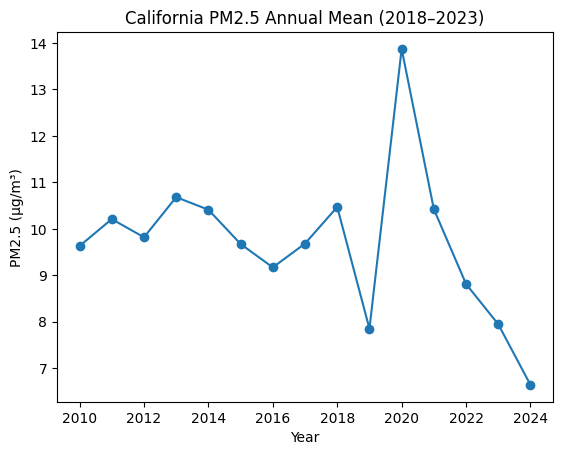

In [1]:
# notebook_demo.ipynb — MCP Query Demo

import requests
import pandas as pd
import matplotlib.pyplot as plt

MCP_SERVER = "http://localhost:8000"

def run_mcp_query(sql_query):
    payload = {"query": sql_query}
    response = requests.post(f"{MCP_SERVER}/v1/query", json=payload)
    result = response.json()
    return pd.DataFrame(result['rows'])

# 1. PM2.5 Trend for California
query_pm25_trend = """
SELECT year, pm25_annual_mean
FROM state_air_quality
WHERE state = 'California'
ORDER BY year;
"""
df_pm25 = run_mcp_query(query_pm25_trend)
plt.plot(df_pm25['year'], df_pm25['pm25_annual_mean'], marker='o')
plt.title('California PM2.5 Annual Mean (2018–2023)')
plt.xlabel('Year')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)
plt.show()

# 2. COPD Prevalence among Smokers 40+
query_copd_smokers = """
SELECT COUNT(*) AS total_smokers_40plus,
       SUM(CASE WHEN MCQ160P = 1 THEN 1 ELSE 0 END) AS copd_among_smokers
FROM nhanes_survey
WHERE SMQ020 = 1 AND RIDAGEYR >= 40;
"""
df_copd_smokers = run_mcp_query(query_copd_smokers)
print(df_copd_smokers)

# 3. COPD Mortality by Sex Over Time
query_copd_mortality = """
SELECT year, sex, SUM(number_of_deaths) AS deaths
FROM wonder_mortality
WHERE cause_of_death LIKE '%J40%' OR cause_of_death LIKE '%J41%' OR cause_of_death LIKE '%J42%' 
   OR cause_of_death LIKE '%J43%' OR cause_of_death LIKE '%J44%'
GROUP BY year, sex
ORDER BY year, sex;
"""
df_mortality = run_mcp_query(query_copd_mortality)
for sex in df_mortality['sex'].unique():
    df_subset = df_mortality[df_mortality['sex'] == sex]
    plt.plot(df_subset['year'], df_subset['deaths'], label=sex)
plt.title('COPD Mortality by Sex (2018–2023)')
plt.xlabel('Year')
plt.ylabel('Number of Deaths')
plt.legend()
plt.grid(True)
plt.show()

# 4. County-Level COPD Prevalence Map
query_places_copd = """
SELECT state, county_name, copd_prevalence
FROM places_health
WHERE copd_prevalence IS NOT NULL;
"""
df_places = run_mcp_query(query_places_copd)
print(df_places.head())

# 5. PM2.5 vs COPD Deaths Correlation by State
query_correlation = """
SELECT saq.state, saq.year, saq.pm25_annual_mean, wm.total_deaths
FROM state_air_quality AS saq
JOIN (
    SELECT state, year, SUM(number_of_deaths) AS total_deaths
    FROM wonder_mortality
    WHERE cause_of_death LIKE '%J40%' OR cause_of_death LIKE '%J41%' OR cause_of_death LIKE '%J42%'
       OR cause_of_death LIKE '%J43%' OR cause_of_death LIKE '%J44%'
    GROUP BY state, year
) AS wm
ON saq.state = wm.state AND saq.year = wm.year;
"""
df_correlation = run_mcp_query(query_correlation)
plt.scatter(df_correlation['pm25_annual_mean'], df_correlation['total_deaths'])
plt.xlabel('PM2.5 Annual Mean (µg/m³)')
plt.ylabel('Total COPD Deaths')
plt.title('PM2.5 vs COPD Deaths (State-Level)')
plt.grid(True)
plt.show()
